In [49]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

% matplotlib inline

pd.set_option('display.mpl_style', 'default')
# plt.rcParams['figure.figsize'] = (15, 3)
plt.rcParams['font.family'] = 'sans-serif'


In [50]:
hiv1625 = pd.read_csv('/home/kristy/Downloads/newHIV/1625Data.txt', index_col=None, header=None, names=['octomer', 'flag'])

In [51]:
hiv1625.head()

,octomer,flag
0,SLNLRETN,1
1,AECFRIFD,1
2,HLVEALYL,1
3,TQIMFETF,1
4,AEELAEIF,1


In [52]:
hiv1625.dtypes

octomer    object
flag        int64
dtype: object

# Define features 

In [53]:
for i, col in enumerate(['aa0','aa1','aa2','aa3','aa4','aa5','aa6','aa7']):
    hiv1625[col] = hiv1625.octomer.str.slice(start=i,stop=(i+1))
hiv1625.head()

,octomer,flag,aa0,aa1,aa2,aa3,aa4,aa5,aa6,aa7
0,SLNLRETN,1,S,L,N,L,R,E,T,N
1,AECFRIFD,1,A,E,C,F,R,I,F,D
2,HLVEALYL,1,H,L,V,E,A,L,Y,L
3,TQIMFETF,1,T,Q,I,M,F,E,T,F
4,AEELAEIF,1,A,E,E,L,A,E,I,F


In [54]:
all_possible = np.unique(hiv1625.aa0.values)
print all_possible.shape

(20,)


In [55]:
le = LabelEncoder()
le.fit(all_possible)
le.classes_

array(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P',
       'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], dtype=object)

In [56]:
# just convert amino acids to factor variables
# old_cols = ['aa0','aa1','aa2','aa3','aa4','aa5','aa6','aa7']
# new_cols = ['fact0','fact1','fact2','fact3','fact4','fact5','fact6','fact7']
# for i in range(8):
#     hiv1625[new_cols[i]] = le.transform(hiv1625[old_cols[i]])
# residues = hiv1625[new_cols]

# convert amino acids to dummy variables
residues = pd.get_dummies(hiv1625, columns=['aa0','aa1','aa2','aa3','aa4','aa5','aa6','aa7'])
residues.drop(['octomer','flag'], axis=1, inplace=True)
residues.head()

,aa0_A,aa0_C,aa0_D,aa0_E,aa0_F,aa0_G,aa0_H,aa0_I,aa0_K,aa0_L,...,aa7_M,aa7_N,aa7_P,aa7_Q,aa7_R,aa7_S,aa7_T,aa7_V,aa7_W,aa7_Y
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
labels = hiv1625.flag
print labels.shape
print type(labels)

(1625,)
<class 'pandas.core.series.Series'>


# Split into training and validation sets 

In [58]:
train_features, valid_features, train_labels, valid_labels = train_test_split(residues, labels)

In [59]:
print(train_features.shape)
print(train_labels.shape)

(1218, 160)
(1218,)


# Exploratory data analysis

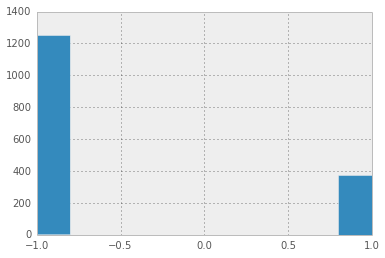

In [60]:
labels.hist();

In [61]:
labels.value_counts()

-1    1250
 1     375
dtype: int64

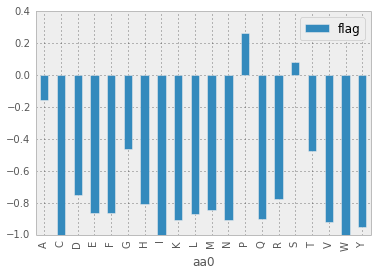

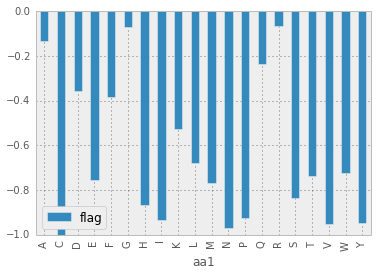

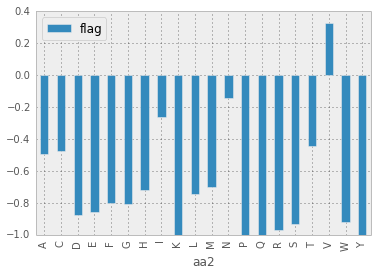

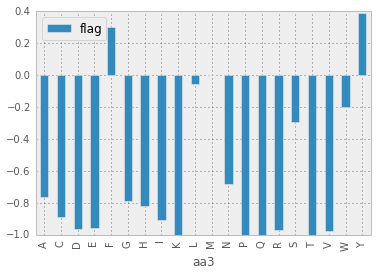

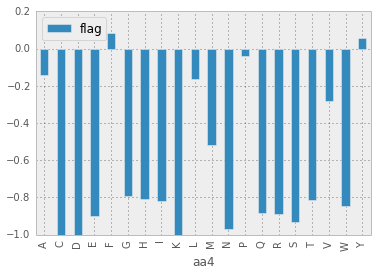

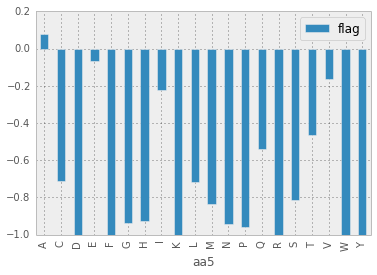

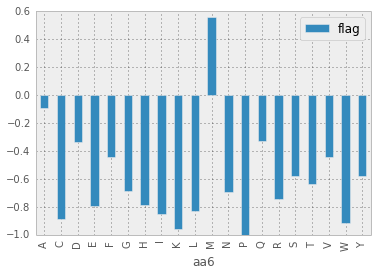

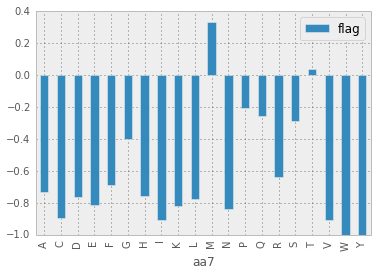

In [62]:
for col in ['aa0','aa1','aa2','aa3','aa4','aa5','aa6','aa7']:
    hiv1625[['flag',col]].groupby(col).aggregate(np.mean).plot(kind='bar');

# Create model

## Logistic regression (all features) 

In [63]:
reg = LogisticRegression()
reg.fit(X=train_features, y=train_labels)
reg.intercept_
reg.coef_
print reg.score(train_features,train_labels)
print reg.score(valid_features,valid_labels)

0.981116584565
0.95085995086


In [64]:
train_pred = reg.predict(train_features)
valid_pred = reg.predict(valid_features)

train_conf = confusion_matrix(train_labels, train_pred)
valid_conf = confusion_matrix(valid_labels, valid_pred)

In [65]:
print train_conf
print "true negative:", str(1.*train_conf[0,0]/np.sum(train_conf[0]))
print "true positive:", str(1.*train_conf[1,1]/np.sum(train_conf[1]))

[[923  10]
 [ 13 272]]
true negative: 0.989281886388
true positive: 0.954385964912


In [66]:
print valid_conf
print "true negative:", str(1.*valid_conf[0,0]/np.sum(valid_conf[0]))
print "true positive:", str(1.*valid_conf[1,1]/np.sum(valid_conf[1]))

[[309   8]
 [ 12  78]]
true negative: 0.97476340694
true positive: 0.866666666667


## Feature reduction 

In [67]:
# do PCA
pca_full = PCA()
pca_full.fit(train_features)

PCA(copy=True, n_components=None, whiten=False)

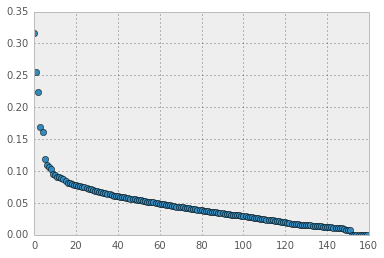

In [68]:
plt.plot(pca_full.explained_variance_,'o');

In [69]:
pca_full.explained_variance_[:10]

array([ 0.31659472,  0.25587255,  0.22448403,  0.16976758,  0.16118054,
        0.11944337,  0.10908635,  0.10661718,  0.10328128,  0.09482584])

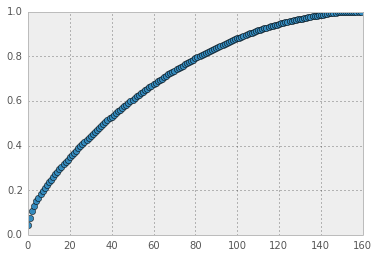

In [70]:
plt.plot(np.cumsum(pca_full.explained_variance_ratio_),'o');

In [138]:
pca = PCA(n_components=10)
pca.fit(train_features)
print sum(pca.explained_variance_ratio_)

0.220293808198


0.16496666798902743

In [72]:
pca95 = PCA(0.9)
train_trans = pca95.fit_transform(train_features)
print train_trans.shape

(1218, 107)


In [122]:
train_features.shape

(1218, 160)